# Analyzing KC Housing Data using Linear Regression
First downloading the data.  We are looking at housng data from homes which come from the King County area in Seattle.  The scenario is for an investor looking to invest in homes in this area that will turn a profit.  The data comes from open source data from the king county website as well as information on airbnbs in this area from the Airbnb website.  Unfortunately when I tried to merge the two sets of data it caused the linear model for the KC housing data to become unfavorable with low R2 values and high p values.  However after analyzing the data from Airbnb we know that the homes with high review ratings and a monthly rate within the desired interquartile range will have between 0 and 6 bedrooms, .5 and 4 baths, and will be in the same zipcodes as out KC housng data. 

In [341]:
import pandas as pd
import numpy as np
import pylab
import math
import os

In [342]:
import matplotlib.pyplot as plt
import seaborn as sns

In [343]:
from scipy import stats

In [344]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [345]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
%matplotlib inline

In [346]:
df = pd.read_csv('data/kc_house_data.csv')

In [347]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


In [348]:
#taking a look into data types.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [349]:
#looking at the data to see if anything stands out within the interquartile ranges as well as max, min, and mean.

df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## Cleaning the data.

In [350]:
# First dropping date.  I am not interested in the time of year this sells as it will be a rental unit. 
#Also dropping square foot basement.  It is another object that has no use for me.
df.drop('date', inplace = True, axis = 1)

In [351]:
df.drop('sqft_basement', inplace = True, axis = 1)

In [352]:
#checking to see it worked.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     19221 non-null  float64
 8   view           21534 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17755 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  int64  
 18  sqft_l

In [353]:
#changing everything to a float so that I can use a z score multiplier on it later.

df.astype('float')

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7.129301e+09,221900.0,3.0,1.00,1180.0,5650.0,1.0,NaN,0.0,3.0,7.0,1180.0,1955.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0
1,6.414100e+09,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,1951.0,1991.0,98125.0,47.7210,-122.319,1690.0,7639.0
2,5.631500e+09,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,1933.0,NaN,98028.0,47.7379,-122.233,2720.0,8062.0
3,2.487201e+09,604000.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,1965.0,0.0,98136.0,47.5208,-122.393,1360.0,5000.0
4,1.954401e+09,510000.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,1987.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2.630000e+08,360000.0,3.0,2.50,1530.0,1131.0,3.0,0.0,0.0,3.0,8.0,1530.0,2009.0,0.0,98103.0,47.6993,-122.346,1530.0,1509.0
21593,6.600060e+09,400000.0,4.0,2.50,2310.0,5813.0,2.0,0.0,0.0,3.0,8.0,2310.0,2014.0,0.0,98146.0,47.5107,-122.362,1830.0,7200.0
21594,1.523300e+09,402101.0,2.0,0.75,1020.0,1350.0,2.0,0.0,0.0,3.0,7.0,1020.0,2009.0,0.0,98144.0,47.5944,-122.299,1020.0,2007.0
21595,2.913101e+08,400000.0,3.0,2.50,1600.0,2388.0,2.0,NaN,0.0,3.0,8.0,1600.0,2004.0,0.0,98027.0,47.5345,-122.069,1410.0,1287.0


In [354]:
#Dropping all NaN values.
df = df.dropna(axis = 0)

In [355]:
#check for nulls
display(df.isnull().any())
df.shape

id               False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

(15762, 19)

In [356]:
df.isnull().sum()

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [357]:
#looking to see that the shape is smaller from dropped values.
df.shape

(15762, 19)

In [358]:
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,1951,1991.0,98125,47.7210,-122.319,1690,7639
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,3,11,3890,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,7,1715,1995,0.0,98003,47.3097,-122.327,2238,6819


## Exploring the data for further cleaning:
I am looking at histograms of all of the columns to see what looks like it is going to be categorical, continuous, and to see if any shapes are different from the normal distribution therefore requiring further attention.  Right away we can see that the price, bedrooms, bathrooms, condition, yr_renovated, ext., all have heavy skews implying that there are some outliers that would prevent us from having normally distributed data.


array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>],
       [<AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'floors'}>,
        <AxesSubplot:title={'center':'waterfront'}>],
       [<AxesSubplot:title={'center':'view'}>,
        <AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'sqft_above'}>],
       [<AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'yr_renovated'}>,
        <AxesSubplot:title={'center':'zipcode'}>,
        <AxesSubplot:title={'center':'lat'}>],
       [<AxesSubplot:title={'center':'long'}>,
        <AxesSubplot:title={'center':'sqft_living15'}>,
        <AxesSubplot:title={'center':'sqft_lot15'}>, <AxesSubplot:>]],
      dtype=objec

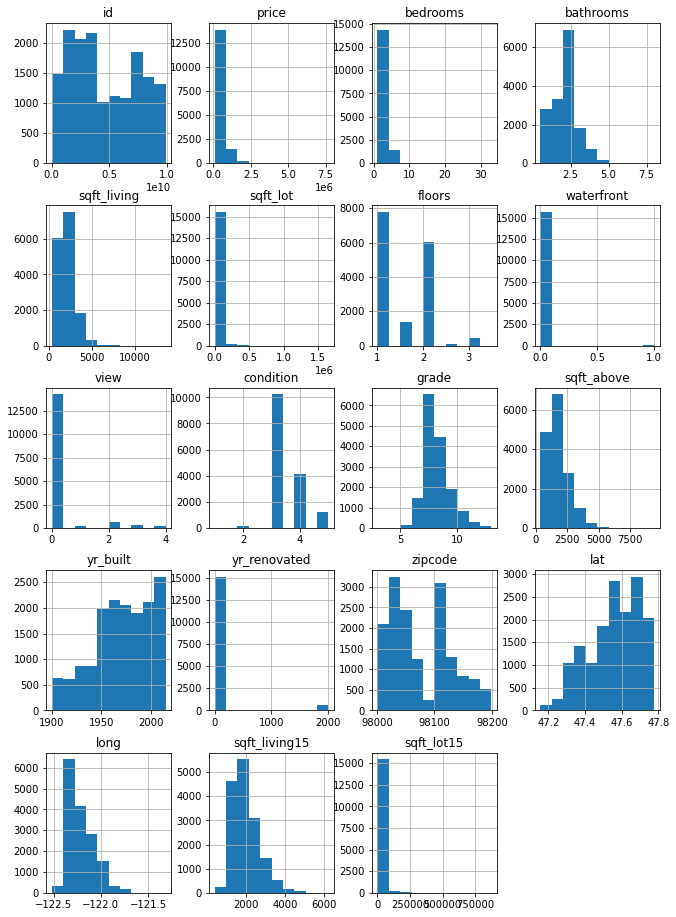

In [359]:
df.hist(figsize = (11,16))

### Separating out by continuous and categorical data.
Below is code for separating out the columns to find out what is categorical and what is quatitative.  

In [360]:
conts= []
cats= []
for col in df.columns:
    if (df[col].nunique() < 25):
        cats.append(col)
    else: 
        conts.append(col)

In [361]:
df_conts = df.loc[:,conts]

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'sqft_living'}>],
       [<AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'sqft_above'}>,
        <AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'yr_renovated'}>],
       [<AxesSubplot:title={'center':'zipcode'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'long'}>,
        <AxesSubplot:title={'center':'sqft_living15'}>],
       [<AxesSubplot:title={'center':'sqft_lot15'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

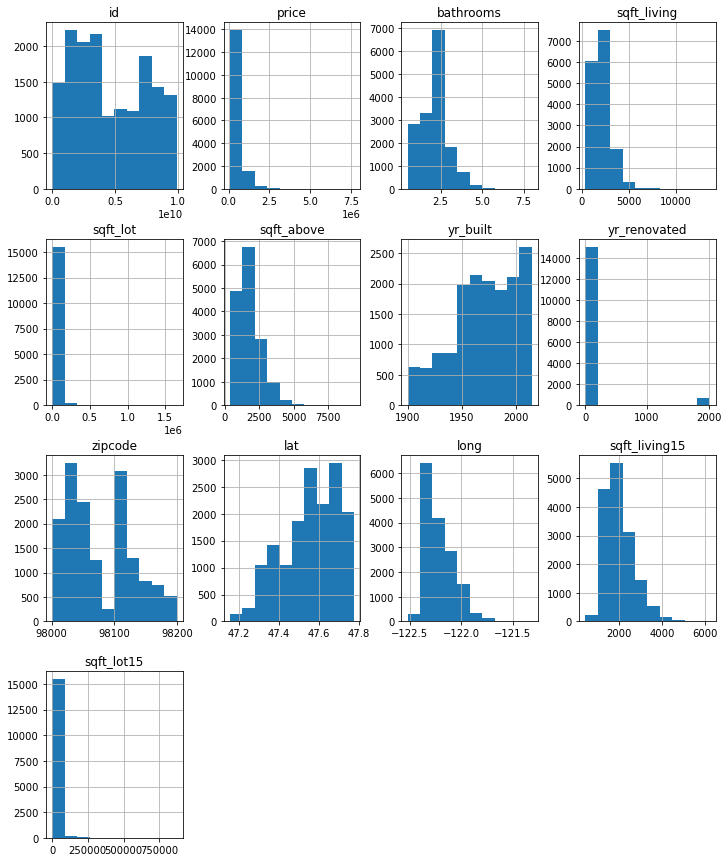

In [362]:
df_conts.hist(figsize = (12,15))

In [363]:
df_cats = df.loc[:,cats]

array([[<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'floors'}>],
       [<AxesSubplot:title={'center':'waterfront'}>,
        <AxesSubplot:title={'center':'view'}>],
       [<AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>]], dtype=object)

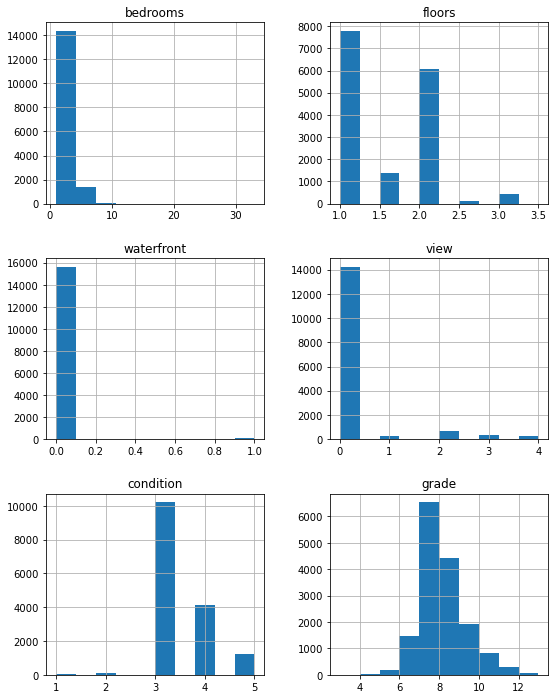

In [364]:
df_cats.hist(figsize = (9,12))

In [365]:
list(df_conts.columns)

['id',
 'price',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [366]:
#I am going to use these as the columns that I get dummies for.
list(df_cats.columns)

['bedrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

## Removing outliers
I really wanted to use a z score because of the fact that it is more agressive and requires less time picking through individual columns.  This data set was large enough that I was able to use the z score method with a little additional cleaning.

#### yr_renovated
yr_renovated is an important column for this expoloratory analysis. However because most of the homes have not been renovated they are marked with 0 and therefore it is hard to make this appear as continuous data with out splitting up the data frame. It also becomes thrown off when put into a z score. This means for the final model I think I am going to end up dropping this column and exploring the data associated with this column in separate notebooks.

In [367]:
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df = df[filtered_entries]

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>],
       [<AxesSubplot:title={'center':'sqft_living'}>,
        <AxesSubplot:title={'center':'sqft_lot'}>,
        <AxesSubplot:title={'center':'floors'}>,
        <AxesSubplot:title={'center':'waterfront'}>],
       [<AxesSubplot:title={'center':'view'}>,
        <AxesSubplot:title={'center':'condition'}>,
        <AxesSubplot:title={'center':'grade'}>,
        <AxesSubplot:title={'center':'sqft_above'}>],
       [<AxesSubplot:title={'center':'yr_built'}>,
        <AxesSubplot:title={'center':'yr_renovated'}>,
        <AxesSubplot:title={'center':'zipcode'}>,
        <AxesSubplot:title={'center':'lat'}>],
       [<AxesSubplot:title={'center':'long'}>,
        <AxesSubplot:title={'center':'sqft_living15'}>,
        <AxesSubplot:title={'center':'sqft_lot15'}>, <AxesSubplot:>]],
      dtype=objec

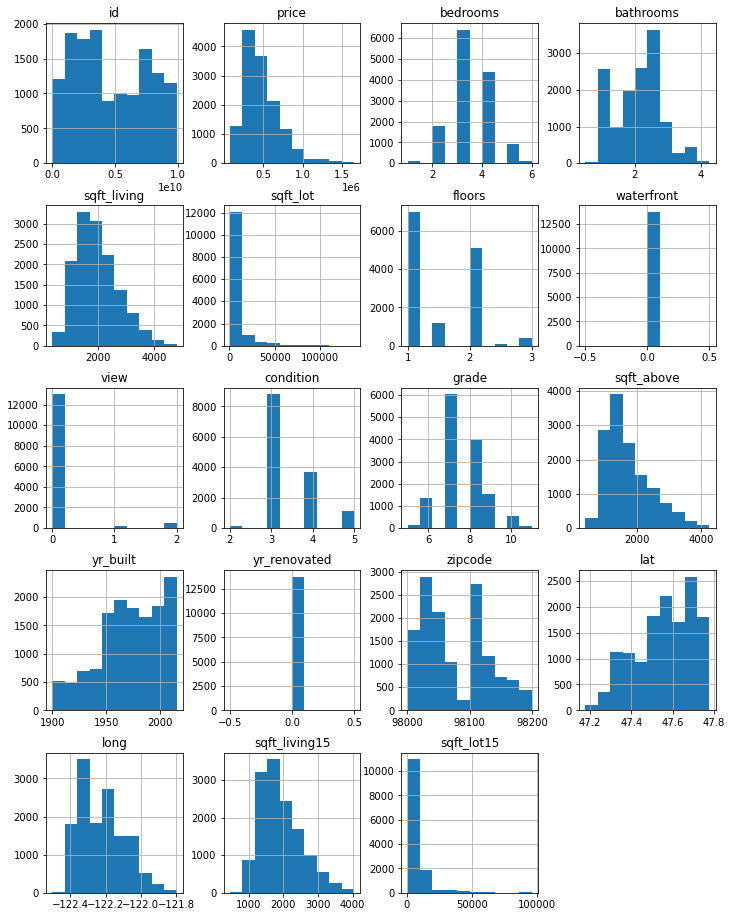

In [368]:
df.hist(figsize = (12,16))

# Exploratory Data Analysis

ValueError: Could not interpret input 'bedrooms'

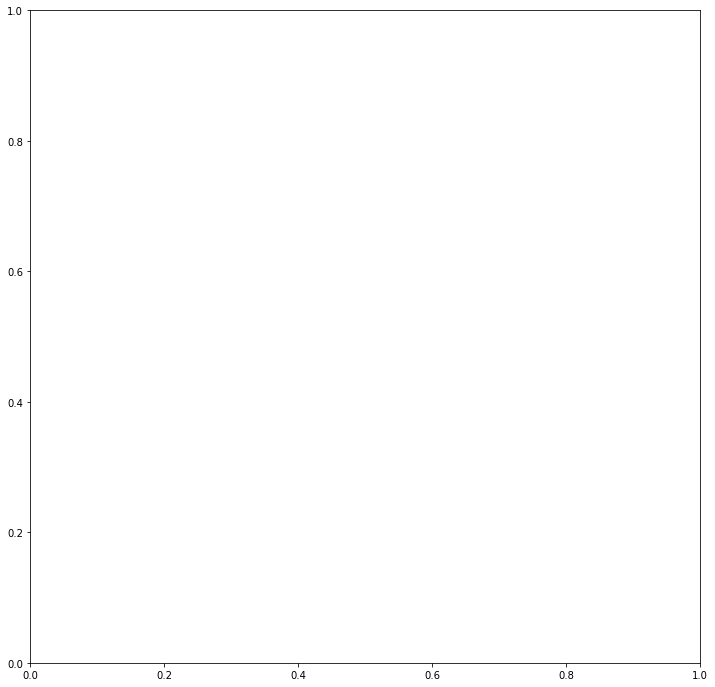

In [407]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 12))

sns.boxplot(data = df, x = 'bedrooms', y = 'price', palette = 'YlGnBu')
plt.show()

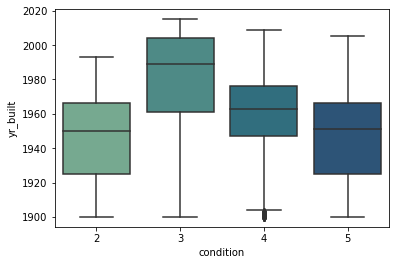

In [370]:
sns.boxplot(data = df, x = 'condition', y = 'yr_built', palette = 'crest')
plt.show()

# Data Preparation for the Model

###  Correlation and Multicollinearity.

In [371]:
#Checking the correlation between columns.
#The Waterfront and yr_renovated columns ended up becoming NaN columns when passed through a correlation matrix.
#This is due to the z score outlier removal method.  
#It flags these columns with 0 as being outliers and therefore turns them into NaN values.
#Since I don't feel I need these columns and I will be exploring renovation stats later I will end up dropping these.
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,0.002103,0.010158,0.029897,0.021317,-0.118189,0.032503,NaN,0.019919,-0.029400,0.033633,0.026770,0.038664,NaN,-0.019391,-0.013680,0.050120,0.022516,-0.110257
price,0.002103,1.000000,0.307282,0.445645,0.627371,0.099006,0.273268,NaN,0.195505,0.050880,0.636901,0.535921,0.063676,NaN,-0.040487,0.429493,0.076473,0.553979,0.091380
bedrooms,0.010158,0.307282,1.000000,0.491848,0.613787,0.114475,0.158953,NaN,0.048182,0.022281,0.341140,0.485935,0.176054,NaN,-0.172980,-0.039415,0.178512,0.412335,0.117993
bathrooms,0.029897,0.445645,0.491848,1.000000,0.709140,0.059099,0.514080,NaN,0.066472,-0.145309,0.619367,0.628483,0.582368,NaN,-0.226793,-0.001226,0.284427,0.539058,0.065158
sqft_living,0.021317,0.627371,0.613787,0.709140,1.000000,0.231026,0.348100,NaN,0.135294,-0.069404,0.714134,0.850045,0.365070,NaN,-0.223851,0.033990,0.312916,0.751380,0.235187
sqft_lot,-0.118189,0.099006,0.114475,0.059099,0.231026,1.000000,-0.105253,NaN,0.028517,0.046079,0.141615,0.205397,0.017849,NaN,-0.180536,-0.051435,0.271369,0.271223,0.817852
floors,0.032503,0.273268,0.158953,0.514080,0.348100,-0.105253,1.000000,NaN,-0.022001,-0.286539,0.466357,0.539260,0.531758,NaN,-0.066477,0.044664,0.156409,0.276374,-0.108478
waterfront,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
view,0.019919,0.195505,0.048182,0.066472,0.135294,0.028517,-0.022001,NaN,1.000000,0.040376,0.113416,0.048599,-0.063688,NaN,0.078877,0.009735,-0.070015,0.151508,0.018097
condition,-0.029400,0.050880,0.022281,-0.145309,-0.069404,0.046079,-0.286539,NaN,0.040376,1.000000,-0.180546,-0.181787,-0.403117,NaN,-0.001660,-0.015314,-0.101743,-0.119648,0.057708


<AxesSubplot:>

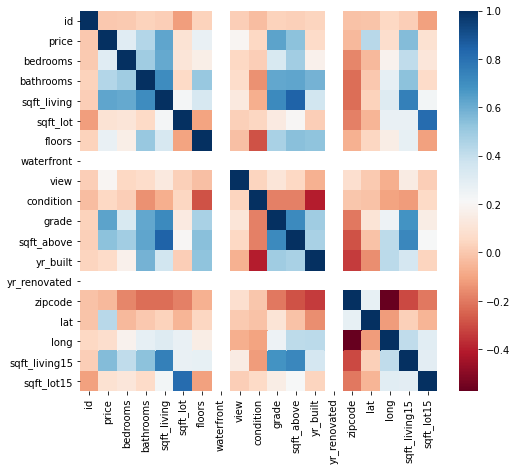

In [372]:
#Looking at the correlation between different columns to check for multicollinearity in a heat map.

plt.figure(figsize = (8,7))
sns.heatmap(df.corr(), cmap = 'RdBu')

### Binning and Labeling
Here I found the cities and towns that correlated with the zipcodes in the data set off of the King County website and binned them accordingly.  I also took the bedroom and bathroom categories and binned them according to Small, Medium, Large and Massive.  After creating bins for these three columns I went on to create dummy variables for any categorical columns.

In [373]:
bins = [0, 98002, 98005, 98010, 98029, 98039, 98049, 98059, 98079, 98199]

In [374]:
labels = ['Auburn', 'Bellvue', 'Black Diamond', 'Federal Way', 'Kirkland/Kent', 'Pacific', 'Renton', 'Sammammish', 'Seattle']

In [375]:
df['hood'] = pd.cut(df['zipcode'], bins, labels = labels)

In [376]:
df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,hood
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,1965,0.0,98136,47.5208,-122.393,1360,5000,Seattle
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,1987,0.0,98074,47.6168,-122.045,1800,7503,Sammammish
6,1321400060,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,7,1715,1995,0.0,98003,47.3097,-122.327,2238,6819,Bellvue
8,2414600126,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,3,7,1050,1960,0.0,98146,47.5123,-122.337,1780,8113,Seattle
9,3793500160,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,3,7,1890,2003,0.0,98038,47.3684,-122.031,2390,7570,Kirkland/Kent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,2997800021,475000.0,3,2.50,1310,1294,2.0,0.0,0.0,3,8,1180,2008,0.0,98116,47.5773,-122.409,1330,1265,Seattle
21592,263000018,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,2009,0.0,98103,47.6993,-122.346,1530,1509,Seattle
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,2014,0.0,98146,47.5107,-122.362,1830,7200,Seattle
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,2009,0.0,98144,47.5944,-122.299,1020,2007,Seattle


These are the bins for the bedrooms:

In [377]:
bins2 = [0, 1, 3, 5, 6]

In [378]:
labels2 = ['Small', 'Medium', 'Large', 'Massive']

In [379]:
df['beds'] = pd.cut(df['bedrooms'], bins = bins2, labels = labels2)

In [380]:
df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,hood,beds
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,1050,1965,0.0,98136,47.5208,-122.393,1360,5000,Seattle,Large
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,1680,1987,0.0,98074,47.6168,-122.045,1800,7503,Sammammish,Medium
6,1321400060,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,...,1715,1995,0.0,98003,47.3097,-122.327,2238,6819,Bellvue,Medium
8,2414600126,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,3,...,1050,1960,0.0,98146,47.5123,-122.337,1780,8113,Seattle,Medium
9,3793500160,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,3,...,1890,2003,0.0,98038,47.3684,-122.031,2390,7570,Kirkland/Kent,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,2997800021,475000.0,3,2.50,1310,1294,2.0,0.0,0.0,3,...,1180,2008,0.0,98116,47.5773,-122.409,1330,1265,Seattle,Medium
21592,263000018,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,...,1530,2009,0.0,98103,47.6993,-122.346,1530,1509,Seattle,Medium
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,...,2310,2014,0.0,98146,47.5107,-122.362,1830,7200,Seattle,Large
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,...,1020,2009,0.0,98144,47.5944,-122.299,1020,2007,Seattle,Medium


Bins for the bathrooms:

In [381]:
bins3 = [0, 1, 3, 5, 6]

In [382]:
labels3 = ['Small', 'Medium', 'Large', 'Massive']

In [383]:
df['baths'] = pd.cut(df['bathrooms'], bins = bins3, labels = labels3)

In [384]:
df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,hood,beds,baths
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,1965,0.0,98136,47.5208,-122.393,1360,5000,Seattle,Large,Medium
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,1987,0.0,98074,47.6168,-122.045,1800,7503,Sammammish,Medium,Medium
6,1321400060,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,...,1995,0.0,98003,47.3097,-122.327,2238,6819,Bellvue,Medium,Medium
8,2414600126,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,3,...,1960,0.0,98146,47.5123,-122.337,1780,8113,Seattle,Medium,Small
9,3793500160,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,3,...,2003,0.0,98038,47.3684,-122.031,2390,7570,Kirkland/Kent,Medium,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,2997800021,475000.0,3,2.50,1310,1294,2.0,0.0,0.0,3,...,2008,0.0,98116,47.5773,-122.409,1330,1265,Seattle,Medium,Medium
21592,263000018,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,...,2009,0.0,98103,47.6993,-122.346,1530,1509,Seattle,Medium,Medium
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,...,2014,0.0,98146,47.5107,-122.362,1830,7200,Seattle,Large,Medium
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,...,2009,0.0,98144,47.5944,-122.299,1020,2007,Seattle,Medium,Small


In [385]:
df.drop(['bedrooms', 'bathrooms', 'zipcode'], axis = 1, inplace = True)

In [386]:
df.head()

,id,price,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,hood,beds,baths
3,2487200875,604000.0,1960,5000,1.0,0.0,0.0,5,7,1050,1965,0.0,47.5208,-122.393,1360,5000,Seattle,Large,Medium
4,1954400510,510000.0,1680,8080,1.0,0.0,0.0,3,8,1680,1987,0.0,47.6168,-122.045,1800,7503,Sammammish,Medium,Medium
6,1321400060,257500.0,1715,6819,2.0,0.0,0.0,3,7,1715,1995,0.0,47.3097,-122.327,2238,6819,Bellvue,Medium,Medium
8,2414600126,229500.0,1780,7470,1.0,0.0,0.0,3,7,1050,1960,0.0,47.5123,-122.337,1780,8113,Seattle,Medium,Small
9,3793500160,323000.0,1890,6560,2.0,0.0,0.0,3,7,1890,2003,0.0,47.3684,-122.031,2390,7570,Kirkland/Kent,Medium,Medium


In [387]:
df = pd.get_dummies(df, columns = ['hood', 'beds', 'baths', 'grade', 'condition', 'view', 'floors'], drop_first = True)

In [388]:
df.shape

(13724, 41)

# Building the Model
**Assumptions Looked At:**
Variance Inflation Factor
<br>
Residual Plots

Homoscedasticity Tests: Brueusch Pagan test.
<br> 
Mean Square Error/ Root Mean Square Error

## Variance Inflation Factor

The numerical value for VIF tells you (in decimal form) what percentage the variance (i.e. the standard error squared) is inflated for each coefficient. For example, a VIF of 1.9 tells you that the variance of a particular coefficient is 90% bigger than what you would expect if there was no multicollinearity — if there was no correlation with other predictors.

This definition was taken from statisticshowto.com.


When calculating VIF a constant was added. From what I have found there seems to be debate as to whether to use one or not.  Below is the best argument I have found as to why to use one:

A large vif in the constant indicates that the (slope) explanatory variables have also a large constant component. An example would be when a variable has a large mean but only a small variance. An example for perfect collinearity with the constant and rank deficiency of the design matrix is the dummy variable trap, when we did not remove one of the levels of a categorical variable in dummy encoding and the dummies sum to 1 and, therefore, replicate a constant.



In [389]:
#Variance Inflation Factor
#This is some code that I found that checks for the severity of multicollinearity within a regression model.
#A variance inflation factor higher than 5 will show signs of multicollinearity and need to be dropped.

X1 = sm.tools.add_constant(df)

series_before = pd.Series([variance_inflation_factor(X1.values, i ) for i in range(X1.shape[1])], index = X1.columns)

print('DATA BEFORE')
print('-'*100)
display(series_before)


#dropping columns i think will cause problems or that I don't feel like I need.
df_1_after = df.drop(['id', 'sqft_living15', 'sqft_lot15', 'sqft_lot', 'sqft_above', 'waterfront', "yr_renovated", 'baths_Massive', 'grade_7', 'hood_Renton', 'grade_10' ], axis = 1)
X2 = sm.tools.add_constant(df_1_after)
series_after = pd.Series([variance_inflation_factor(X2.values, i ) for i in range(X2.shape[1])], index = X2.columns)

print('DATA AFTER')
print('-'*100)
display(series_after)

C:\Users\ozbun\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\ozbun\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


DATA BEFORE
----------------------------------------------------------------------------------------------------


const                  0.000000
id                     1.037789
price                  3.445376
sqft_living            6.865654
sqft_lot               3.092263
waterfront                  NaN
sqft_above             6.638797
yr_built               3.281335
yr_renovated                NaN
lat                    1.823325
long                   2.843296
sqft_living15          3.183639
sqft_lot15             3.199293
hood_Bellvue           2.278336
hood_Black Diamond     2.794664
hood_Federal Way       4.916976
hood_Kirkland/Kent     4.883157
hood_Pacific           2.444111
hood_Renton            5.546835
hood_Sammammish        4.531122
hood_Seattle          11.176118
beds_Medium           32.146054
beds_Large            33.239035
beds_Massive           2.312305
baths_Medium           2.219371
baths_Large            2.113968
baths_Massive               NaN
grade_6               10.124410
grade_7               27.776530
grade_8               25.311825
grade_9               14.279349
grade_10

DATA AFTER
----------------------------------------------------------------------------------------------------


const                 2.655541e+06
price                 2.986607e+00
sqft_living           3.505307e+00
yr_built              3.148909e+00
lat                   1.668795e+00
long                  2.618260e+00
hood_Bellvue          1.290027e+00
hood_Black Diamond    1.286245e+00
hood_Federal Way      1.534674e+00
hood_Kirkland/Kent    1.545360e+00
hood_Pacific          1.245704e+00
hood_Sammammish       1.594213e+00
hood_Seattle          3.683633e+00
beds_Medium           3.126166e+01
beds_Large            3.235380e+01
beds_Massive          2.270997e+00
baths_Medium          2.126952e+00
baths_Large           2.055246e+00
grade_6               1.353026e+00
grade_8               1.367203e+00
grade_9               1.570324e+00
grade_11              1.120082e+00
condition_3           3.080860e+01
condition_4           2.655885e+01
condition_5           1.084101e+01
view_1.0              1.032606e+00
view_2.0              1.063889e+00
floors_1.5            1.261041e+00
floors_2.0          

In [390]:
### Turning the price category into a log10 transformation to ensure that the price data is not 
###skewed without dropping more outliers.  
##This should also help result in a high R2.  

In [391]:
df_1_after['price_log'] = np.log10(df_1_after['price'])

### Testing and training data.

In [392]:
# Setting out X and y equal to their respective columns.
X = df_1_after.drop('price_log', axis = 1)
y = df_1_after[['price_log']]

#Split dataset into training and testing portion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

#create instance of our model
regression_model = LinearRegression()
#fit the model
regression_model.fit(X_train, y_train)

LinearRegression()

In [393]:
len(X_test)

2745

In [394]:
y_hat_train = regression_model.predict(X_train)
y_hat_test = regression_model.predict(X_test)

In [395]:
mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)

#### Mean Square Error

In [396]:
print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

Train MSE: 0.0024020923688656323
Test MSE: 0.0024610298667375147


#### Root Mean Square Error

In [397]:
print('RMSE Train:', np.sqrt(mse_train))
print('RMSE Test:', np.sqrt(mse_test))

RMSE Train: 0.04901114535353803
RMSE Test: 0.04960876804293284


In [398]:
residual = y_test - y_hat_test

In [399]:
#plot for residuals was skewed left heavily before changing the price to a log transformation.

C:\Users\ozbun\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

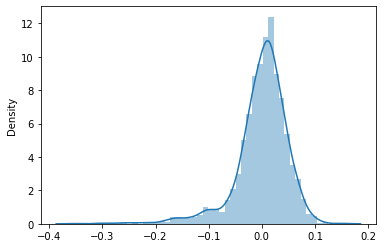

In [400]:
sns.distplot(residual)

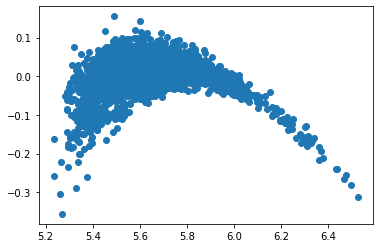

In [401]:
plt.scatter(y_hat_test, residual)

In [402]:
r2_score(y_test, y_hat_test)

0.9370545296694764

#### Fitting the final model.

In [403]:
X_1 = sm.add_constant(X)
model = sm.OLS(y, X_1)
est = model.fit()

#### Homoscedasticity Checks:
Homoscedasticity checks using breusch pagan test:


Null Hypothesis:  All error variances are equal
Alternative Hypothesis:  Error variances are not equal, i.e.: The more that Y increases, X also increases or decreases causing a conical shape.  

We want for our null hypothesis to be true!

Note the problem with this test is that the error variances could be caused by something other than the linear function itself.

In [404]:
_, pval, _, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
print(pval, f_pval)

0.0 0.0


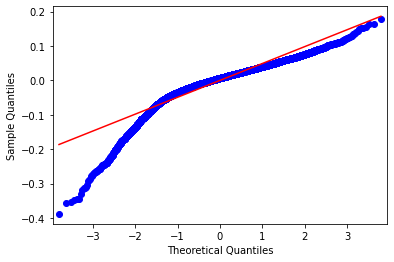

Mean: 1.140764978512912e-11


In [405]:
#check for the normality of the residuals
sm.qqplot(est.resid, line = 's')
pylab.show()

#check that the mean of the residuals is approx. 0
mean_residuals = sum(est.resid) / len(est.resid)
print("Mean:", mean_residuals)

In [406]:
##The final model:

print(est.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     7139.
Date:                Sun, 02 May 2021   Prob (F-statistic):               0.00
Time:                        09:29:11   Log-Likelihood:                 21885.
No. Observations:               13724   AIC:                        -4.371e+04
Df Residuals:                   13693   BIC:                        -4.347e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.2852      0

## Summary

In summation there is still work to be done.  We can begin to narrow the search down to specific neighborhoods, specific number of bedrooms and bathrooms, and looking into cost of materials.   

Exploring the Airbnb data even more and looking into world-wide trends with Airbnb data and not just King county.

Building a new model that takes into consideration the world-wide Airbnb trends.

Investigating specific zip codes that could ensure a high ROI.  And building new data sets that are customized to those zip codes.  I.e. what areas are trending both on the housing market as well as the Airbnb market. 

Examining the cost of materials to ensure that even with free labor there would still be a high ROI.